In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install jsonlines

In [ ]:
!pip install tensorflow

In [ ]:
!pip install transformers

In [ ]:
!pip install keras

In [ ]:


import os
import torch
import pickle
import requests
import transformers

import numpy as np
import tensorflow as tf
import pandas as pd

In [ ]:
from tqdm import tqdm
from PIL import Image
from io import BytesIO
from google.colab import drive
from matplotlib import pyplot as plt

from tensorflow.keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Input, concatenate, Dropout
from transformers import AutoTokenizer, TFAutoModel

In [ ]:
# Checking if gpu is available and runnig it on the gpu

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


##**SAVING DATA IN LISTS**

In [ ]:
!unzip /content/drive/MyDrive/drive-download-20240313T105054Z-001.zip

Archive:  /content/drive/MyDrive/drive-download-20240313T105054Z-001.zip
  inflating: dev_unseen.csv          
  inflating: test_unseen.csv         
  inflating: data_train.csv          
  inflating: dev_seen.csv            
  inflating: test_seen.csv           


In [ ]:
import pandas as pd

test_seen_data=pd.read_csv('/content/test_seen.csv')
dev_seen_data=pd.read_csv('/content/dev_seen.csv')
data_train_data=pd.read_csv('/content/data_train.csv')
resized_image_path='/content/Hateful_memes_sizeredu'

In [ ]:
data_train_data

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...


In [ ]:
import pandas as pd
from sklearn.utils import resample

print('Original class distribution:',data_train_data['label'].value_counts())

majority_class=data_train_data[data_train_data['label']==0]
minority_class=data_train_data[data_train_data['label']==1]

majority_class_downsampled=resample(majority_class,replace=False,n_samples=len(minority_class),random_state=42)

balanced_data=pd.concat([majority_class_downsampled, minority_class])

print('Balanced class distribution:',balanced_data['label'].value_counts())


Original class distribution: 0    5481
1    3019
Name: label, dtype: int64
Balanced class distribution: 0    3019
1    3019
Name: label, dtype: int64


In [ ]:
balanced_data

,id,img,label,text
5114,50938,/content/Hateful_memes_sizeredu/img/50938.png,0,how you feel after reading owen's mortificatio...
2800,60532,/content/Hateful_memes_sizeredu/img/60532.png,0,i sold all your games because i'm the only thi...
9,58306,/content/Hateful_memes_sizeredu/img/58306.png,0,what is he hiding? we need to see his tax retu...
6885,26183,/content/Hateful_memes_sizeredu/img/26183.png,0,i'm awesome on the piano but i suck on the organ
1486,97481,/content/Hateful_memes_sizeredu/img/97481.png,0,"not a creature was stirring, not even a mouse...."
...,...,...,...,...
8495,10423,/content/Hateful_memes_sizeredu/img/10423.png,1,nobody wants to hang auschwitz me
8496,98203,/content/Hateful_memes_sizeredu/img/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,/content/Hateful_memes_sizeredu/img/36947.png,1,gays on social media: equality! body positivit...
8498,16492,/content/Hateful_memes_sizeredu/img/16492.png,1,having a bad day? you could be a siamese twin ...


In [ ]:
balanced_data

,id,img,label,text
5114,50938,/content/Hateful_memes_sizeredu/50938.png,0,how you feel after reading owen's mortificatio...
2800,60532,/content/Hateful_memes_sizeredu/60532.png,0,i sold all your games because i'm the only thi...
9,58306,/content/Hateful_memes_sizeredu/58306.png,0,what is he hiding? we need to see his tax retu...
6885,26183,/content/Hateful_memes_sizeredu/26183.png,0,i'm awesome on the piano but i suck on the organ
1486,97481,/content/Hateful_memes_sizeredu/97481.png,0,"not a creature was stirring, not even a mouse...."
...,...,...,...,...
8495,10423,/content/Hateful_memes_sizeredu/10423.png,1,nobody wants to hang auschwitz me
8496,98203,/content/Hateful_memes_sizeredu/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,/content/Hateful_memes_sizeredu/36947.png,1,gays on social media: equality! body positivit...
8498,16492,/content/Hateful_memes_sizeredu/16492.png,1,having a bad day? you could be a siamese twin ...


In [ ]:
train_text_data = np.array(balanced_data['text'].tolist())
dev_seen_text = np.array(dev_seen_data['text'].tolist())
test_data_text = np.array(test_seen_data['text'].tolist())

In [ ]:
len(train_text_data)

6038

In [ ]:
len(train_text_data)

6038

In [ ]:
with open('/content/drive/MyDrive/train_text_data.pickle', 'wb') as f:
    pickle.dump(train_text_data, f)

with open('/content/drive/MyDrive/dev_seen_text.pickle', 'wb') as f:
    pickle.dump(dev_seen_text, f)

with open('/content/drive/MyDrive/test_data_text.pickle', 'wb') as f:
    pickle.dump(test_data_text, f)

In [ ]:
data_train_labels = np.array(balanced_data['label'].tolist())
dev_seen_labels = np.array(dev_seen_data['label'].tolist())
test_data_labels = np.array(test_seen_data['label'].tolist())

In [ ]:
len(data_train_labels)

6038

In [ ]:
with open('/content/drive/MyDrive/data_train_labels.pickle','wb') as f:
    pickle.dump(data_train_labels, f)

with open('/content/drive/MyDrive/dev_seen_labels.pickle','wb') as f:
    pickle.dump(dev_seen_labels, f)

with open('/content/drive/MyDrive/test_data_labels.pickle','wb') as f:
    pickle.dump(test_data_labels, f)

In [ ]:
def load_image(file_path):
    img = Image.open(file_path)
    return img


In [ ]:
!nvidia-smi

Thu Mar 14 13:48:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import tensorflow as tf
import time

# Set TensorFlow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')

print('TRAIN IMAGES')
train_image_data = []
for i, file_path in tqdm(enumerate(balanced_data['img'])):
    with tf.device('/GPU:0'):
        img = load_image(file_path)
        train_image_data.append(img)

print('VAL IMAGES')
val_image_data = []
for i, file_path in tqdm(enumerate(dev_seen_data['img'])):
    with tf.device('/GPU:0'):
        img = load_image(file_path)
        val_image_data.append(img)

print('TEST IMAGES')
test_image_data = []
for i, file_path in tqdm(enumerate(test_seen_data['img'])):
    with tf.device('/GPU:0'):
        img = load_image(file_path)
        test_image_data.append(img)

TRAIN IMAGES


6038it [00:00, 15984.76it/s]


VAL IMAGES


500it [00:00, 1921.09it/s]


TEST IMAGES


1000it [00:00, 18393.09it/s]


In [ ]:
with open('/content/drive/MyDrive/train_image_data.pickle','wb') as f:
    pickle.dump(train_image_data, f)

with open('/content/drive/MyDrive/val_image_data.pickle','wb') as f:
    pickle.dump(val_image_data, f)

with open('/content/drive/MyDrive/test_image_data.pickle','wb') as f:
    pickle.dump(test_image_data, f)

##**PART 1**

In [ ]:
import pickle
with open('/content/drive/MyDrive/train_image_data.pickle','rb') as f:
    img_train = pickle.load(f)

with open('/content/drive/MyDrive/val_image_data.pickle','rb') as f:
    img_val = pickle.load(f)

with open('/content/drive/MyDrive/test_image_data.pickle','rb') as f:
    img_test = pickle.load(f)



with open('/content/drive/MyDrive/train_text_data.pickle','rb') as f:
    txt_train = pickle.load(f)

with open('/content/drive/MyDrive/dev_seen_text.pickle','rb') as f:
    txt_val = pickle.load(f)

with open('/content/drive/MyDrive/test_data_text.pickle','rb') as f:
    txt_test = pickle.load(f)


#

with open('/content/drive/MyDrive/data_train_labels.pickle','rb') as f:
    lbl_train = pickle.load(f)

with open('/content/drive/MyDrive/dev_seen_labels.pickle','rb') as f:
    lbl_val = pickle.load(f)

with open('/content/drive/MyDrive/test_data_labels.pickle','rb') as f:
    lbl_test = pickle.load(f)

In [ ]:
len(img_train)

6038

In [ ]:
len(img_val)

500

In [ ]:
arr_img_train = img_train
arr_txt_train = txt_train
arr_lbl_train = lbl_train

arr_img_val = img_val
arr_txt_val = txt_val
arr_lbl_val = lbl_val

arr_img_test = img_test
arr_txt_test = txt_test
arr_lbl_test = lbl_test

In [ ]:
arr_img_train

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 <PIL.PngImagePlugin.PngImageFile image

In [ ]:
type(arr_img_train[0])

PIL.PngImagePlugin.PngImageFile

In [ ]:
len(arr_img_train)

6038

## Image Preprocessing using InceptionV3

In [ ]:
from PIL import Image
import keras.utils as image

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

96112376/96112376 [==============================] - 1s 0us/step


In [ ]:
def encode(PIL_img):

    img = PIL_img.resize((299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    image_feature_vector = model_new.predict(x)
    image_feature_vector = np.reshape(image_feature_vector, image_feature_vector.shape[1])

    return image_feature_vector

In [ ]:
arr_img_train_encoding = []
remove = []
i = 0

for img in arr_img_train:
  try:
    arr_img_train_encoding.append( encode(img) )

  except:
    remove.append(i)
    i += 1
    continue

  i += 1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step


In [ ]:
with open('/content/drive/MyDrive/arr_img_train_encoding.pickle', 'wb') as f:
    pickle.dump(arr_img_train_encoding, f)

In [ ]:
arr_lbl_train.shape

(6038,)

In [ ]:
arr_img_test_enc = []
remove = []
i = 0

for img in arr_img_test:

  try:
    arr_img_test_enc.append( encode(img) )
  except:
    remove.append(i)
    i += 1
    continue

  i += 1

1/1 [==============================] - 0s 27ms/step


In [ ]:
with open('/content/drive/MyDrive/test_image_encd.pickle', 'wb') as f:
    pickle.dump(arr_img_test_enc, f)

In [ ]:
len(arr_img_test)

1000

In [ ]:
arr_img_val_enc = []
remove = []
i = 0
for img in arr_img_val:

  try:
    arr_img_val_enc.append( encode(img) )
  except:
    remove.append(i)
    i += 1
    continue

  i += 1

1/1 [==============================] - 0s 63ms/step


In [ ]:
with open('/content/drive/MyDrive/val_image_encd.pickle', 'wb') as f:
    pickle.dump(arr_img_val_enc, f)

## Text preprocessing using Bert

In [ ]:
!pip install tensorflow-text

In [ ]:
!pip install transformers
import torch
from transformers import BertTokenizer, BertModel

In [ ]:
bert_preprocess = BertTokenizer.from_pretrained("bert-base-uncased")
bert_encoder = BertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch
from transformers import BertTokenizer, BertModel

def get_sentence_embeding(batch_sentences):
    tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
    model=BertModel.from_pretrained('bert-base-uncased')

    encoded_input=tokenizer(batch_sentences,padding=True,truncation=True,return_tensors='pt')
    output=model(**encoded_input)
    sentence_embeddings=output.last_hidden_state[:, 0, :].detach().numpy()

    return sentence_embeddings

In [ ]:
batch_size=32
num_batches=(len(arr_txt_train)+batch_size-1)//batch_size

arr_txt_train_emb=np.empty((0,768))

for i in range(num_batches):
    batch_start=i*batch_size
    batch_end=(i+1)*batch_size
    batch_sentences=arr_txt_train[batch_start:batch_end].tolist()
    batch_embeddings=get_sentence_embeding(batch_sentences)
    arr_txt_train_emb=np.append(arr_txt_train_emb, batch_embeddings,axis=0)

In [ ]:
arr_txt_train_emb.shape

(6038, 768)

In [ ]:
with open('/content/drive/MyDrive/train_txt_emb.pickle','wb') as f:
    pickle.dump(arr_txt_train_emb, f)

In [ ]:
arr_txt_train.shape

(6038,)

In [ ]:
with open('/content/drive/MyDrive/val_lbl.pickle','wb') as f:
    pickle.dump(arr_lbl_val, f)

In [ ]:
import numpy as np
batch_size=32
num_batches=(len(arr_txt_test)+batch_size-1)//batch_size

arr_txt_test_emb=np.empty((0,768))

for i in range(num_batches):
    batch_start=i*batch_size
    batch_end=(i+1)*batch_size
    batch_sentences=arr_txt_test[batch_start:batch_end].tolist()
    batch_embeddings=get_sentence_embeding(batch_sentences)
    arr_txt_test_emb=np.append(arr_txt_test_emb, batch_embeddings, axis=0)

In [ ]:
with open('/content/drive/MyDrive/test_txt_emb.pickle','wb') as f:
    pickle.dump(arr_txt_test_emb, f)

In [ ]:
batch_size=32
num_batches=(len(arr_txt_val)+batch_size-1) // batch_size

arr_txt_val_emb=np.empty((0, 768))

for i in range(num_batches):
    batch_start=i*batch_size
    batch_end=(i+1)*batch_size
    batch_sentences=arr_txt_val[batch_start:batch_end].tolist()
    batch_embeddings=get_sentence_embeding(batch_sentences)
    arr_txt_val_emb=np.append(arr_txt_val_emb, batch_embeddings, axis=0)

In [ ]:
with open('/content/drive/MyDrive/val_txt_emb.pickle','wb') as f:
    pickle.dump(arr_txt_val_emb, f)

## Loading the embeddings

In [ ]:

import pickle
with open('/content/arr_img_train_encoding.pickle','rb') as f:
    arr_img_train_encoding=pickle.load(f)

with open('/content/val_image_encd.pickle','rb') as f:
    arr_img_val_enc=pickle.load(f)

with open('/content/test_image_encd.pickle','rb') as f:
    arr_img_test_enc=pickle.load(f)

In [ ]:
with open('/content/train_txt_emb.pickle','rb') as f:
    arr_txt_train_emb=pickle.load(f)

with open('/content/val_txt_emb.pickle','rb') as f:
    arr_txt_val_emb=pickle.load(f)

with open('/content/test_txt_emb.pickle','rb') as f:
    arr_txt_test_emb=pickle.load(f)


In [ ]:

with open('/content/data_train_labels.pickle','rb') as f:
    arr_lbl_train=pickle.load(f)

with open('/content/dev_seen_labels.pickle','rb') as f:
    arr_lbl_val=pickle.load(f)

with open('/content/test_data_labels.pickle','rb') as f:
    arr_lbl_test=pickle.load(f)


In [ ]:
import numpy as np
arr_img_train_encoding = np.array(arr_img_train_encoding)
arr_img_test_enc = np.array(arr_img_test_enc)
arr_img_val_enc = np.array(arr_img_val_enc)

## multi-model

In [ ]:
from keras.layers import Input,LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import add
from keras.models import Model

In [ ]:
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, add, Reshape
from tensorflow.keras.models import Model

# Define input layers
inputs1 = Input(shape=(2048,))
inputs2 = Input(shape=(768,))

# Feature extraction layers
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(1024, activation='relu')(fe1)
fe3 = Dense(512, activation='relu')(fe2)

# Sequence processing layers
se1 = Reshape((768, 1))(inputs2)  # add a timestep dimension
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)

# Decoder layers
decoder1 = add([fe3, se3])
decoder2 = Dense(512, activation='relu')(decoder1)
decoder3 = Dense(256, activation='relu')(decoder2)
outputs = Dense(1, activation='sigmoid')(decoder3)

# Define the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 768, 1)               0         ['input_2[0][0]']             
                                                                                              

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# define the checkpoint filepath
checkpoint_filepath = '/conten/drive/MyDrive/checkpoint_middle.h5'

# define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(

    checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)


In [ ]:

min_samples=min(len(arr_img_train_encoding),len(arr_txt_train_emb),len(arr_lbl_train))
arr_img_train_encoding=arr_img_train_encoding[:min_samples]
arr_txt_train_emb=arr_txt_train_emb[:min_samples]
arr_lbl_train=arr_lbl_train[:min_samples]

min_samples_val=min(len(arr_img_val_enc), len(arr_txt_val_emb), len(arr_lbl_val))
arr_img_val_enc=arr_img_val_enc[:min_samples_val]
arr_txt_val_emb=arr_txt_val_emb[:min_samples_val]
arr_lbl_val=arr_lbl_val[:min_samples_val]

# Now the sizes should be consistent
print("x sizes:",len(arr_img_train_encoding),len(arr_txt_train_emb))
print("y sizes:",len(arr_lbl_train))

# Train the model
history = model.fit(
    x=[arr_img_train_encoding, arr_txt_train_emb],
    y=arr_lbl_train,
    epochs=20,
    batch_size=64,
    validation_data=([arr_img_val_enc, arr_txt_val_emb], arr_lbl_val),
    verbose=1,
    callbacks=[checkpoint],
    validation_batch_size=64
)



x sizes: 6035 6035
y sizes: 6035
Epoch 1/20
95/95 [==============================] - ETA: 0s - loss: 0.6676 - accuracy: 0.5930
Epoch 1: val_accuracy did not improve from 0.53307
95/95 [==============================] - 13s 136ms/step - loss: 0.6676 - accuracy: 0.5930 - val_loss: 0.7045 - val_accuracy: 0.5251
Epoch 2/20
95/95 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.5942
Epoch 2: val_accuracy improved from 0.53307 to 0.53908, saving model to /conten/drive/MyDrive/checkpoint_middle.h5
95/95 [==============================] - 14s 143ms/step - loss: 0.6542 - accuracy: 0.5942 - val_loss: 0.7216 - val_accuracy: 0.5391
Epoch 3/20
95/95 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.6169
Epoch 3: val_accuracy did not improve from 0.53908
95/95 [==============================] - 13s 140ms/step - loss: 0.6456 - accuracy: 0.6169 - val_loss: 0.7103 - val_accuracy: 0.5010
Epoch 4/20
95/95 [==============================] - ETA: 0s - loss: 0.64

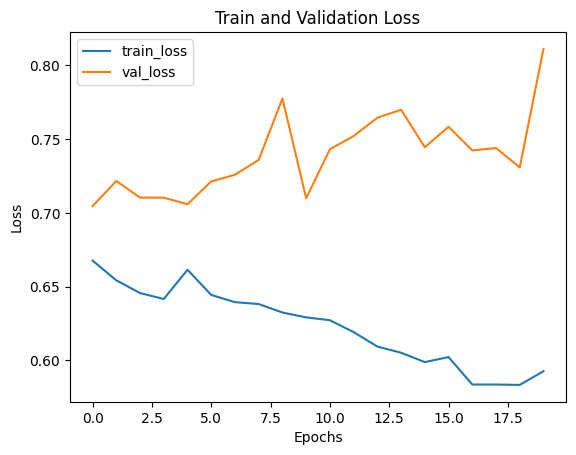

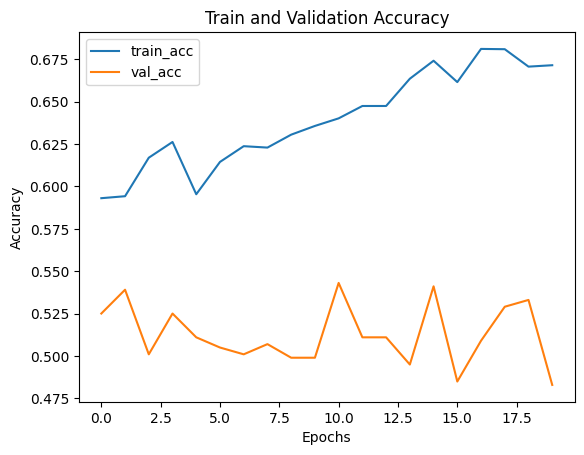

In [ ]:
import matplotlib.pyplot as plt

# Plot train and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot train and validation accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Multi_Modal.h5')